<a href="https://colab.research.google.com/github/audalsgh/20250708/blob/main/0708_python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Google Colab 신호등 인식 테스트 ===
1. upload_and_detect() - 기본 검출
2. adjust_parameters_and_test() - 파라미터 비교 테스트

사용법:
upload_and_detect()  # 이 함수를 실행하세요
이미지 파일을 선택해주세요...


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (2).png

처리중: KakaoTalk_20250708_085906042 (2).png


/tmp/ipython-input-6-621487649.py:127: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


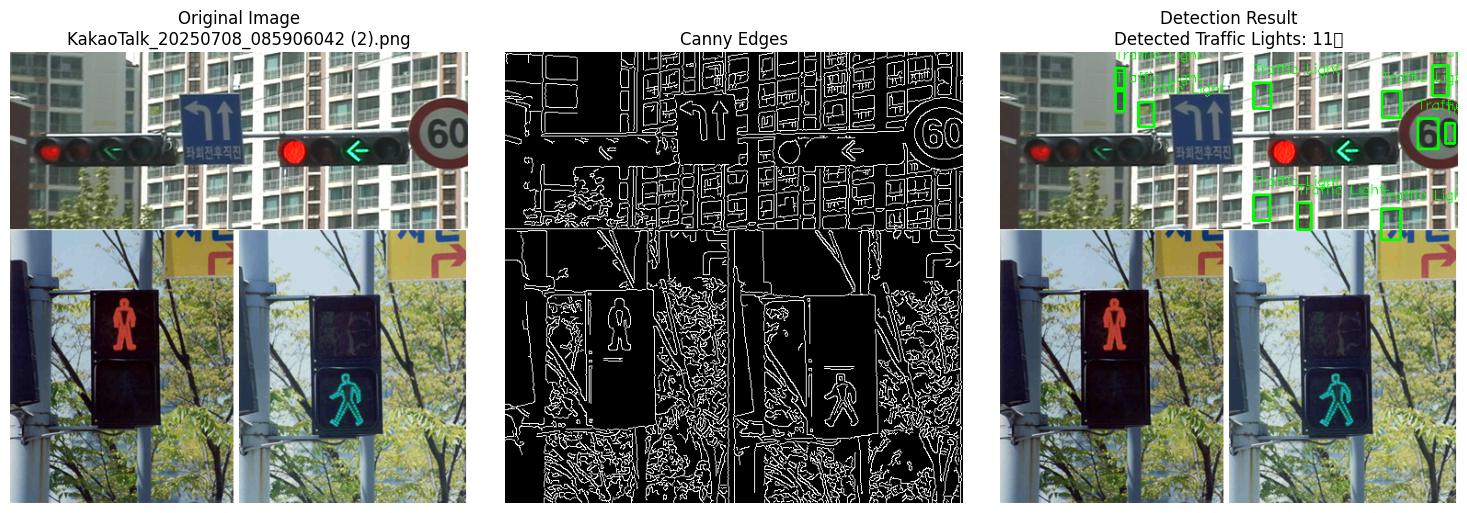

검출된 신호등 개수: 11
  신호등 1: 위치=(414, 170), 크기=(21x34)
  신호등 2: 위치=(323, 164), 크기=(15x29)
  신호등 3: 위치=(275, 155), 크기=(18x28)
  신호등 4: 위치=(484, 77), 크기=(10x22)
  신호등 5: 위치=(454, 72), 크기=(22x33)
  신호등 6: 위치=(150, 54), 크기=(17x27)
  신호등 7: 위치=(415, 42), 크기=(20x29)
  신호등 8: 위치=(125, 42), 크기=(10x22)
  신호등 9: 위치=(275, 33), 크기=(19x28)
  신호등 10: 위치=(125, 17), 크기=(10x22)
  신호등 11: 위치=(470, 14), 크기=(17x33)


In [6]:
# 1.결과 잡다한 신호등 인식 윗쪽 40퍼센트 정도만 감지 Google Colab에서 이미지 업로드하여 신호등 인식하는 예제
# 아직 불완전하여 신호등을 똑바로 인식하지 못하는 결과.

import cv2  # OpenCV: 컴퓨터 비전·영상처리 라이브러리
import numpy as np  # NumPy: 수치 계산 배열 라이브러리를 가져오고, 별칭을 np로 한다.
import matplotlib.pyplot as plt  # Matplotlib: 결과 시각화 라이브러리를 가져오고, 별칭을 plt로 한다.
from google.colab import files  # Colab 전용 파일 업로드 도구
from PIL import Image  # PIL: 이미지 입출력 및 변환
import io  # 메모리 바이트 스트림 처리, PIL과 io가 있어야 openCV에 바이트 데이터를 이미지로 넣을수 있게된다.

def detect_traffic_light_canny(image):
    """
    Canny 엣지 검출만을 사용한 신호등 인식,  # Gray → Blur → Canny: 컬러 이미지를 그레이스케일로 줄여 계산량 감소, 블러로 작은 노이즈 완화, Canny로 에지(경계) 검출
    """
    # 그레이스케일 변환, BGR 순서의 3채널 컬러 이미지, BGR to Grayscale(그레이스케일) 변환을 의미
    # OpenCV에는 cv2.COLOR_BGR2RGB, cv2.COLOR_RGB2HSV 등 다양한 변환 코드가 존재함.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 가우시안 블러로 노이즈 제거, 보통 위에서 그레이스케일 변환한 이미지 gray를 넣고 블러처리를 함.
    # 커널(kernel) 크기 = (5,5). 가우시안 필터가 적용될 윈도우 크기를 (가로, 세로) 형태로 지정합니다. 짝수 대신 홀수를 주는 게 일반적.
    #	sigmaX 값: 가우시안 분포의 표준편차. 0을 쓰면 OpenCV가 자동으로 커널 크기에 맞춰 값을 계산함.
    # sigmaY(수직 표준편차)를 따로 지정하려면 네 번째 인자 사용. 보통 sigmaX만 설정해도 충분.
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Canny 엣지 검출, 보통 블러처리하여 노이즈를 줄인 이미지인 blurred를 넣어야 안정적인 결과를 얻음.
    # (lower threshold) 에지로 확실히 볼 수 있는 픽셀 강도 기준.
    # (upper threshold) 이 값보다 강한 경계만 확실한 엣지로 바로 검출함.
    edges = cv2.Canny(blurred, 50, 150)

    # 컨투어 찾기, 윤곽선을 찾아 각각의 모양 정보 얻기
    # 외곽선(Contour)을 찾을 이진화 이미지엔 보통 Canny 엣지 검출 결과나 cv2.threshold 결과를 넣음.
    # Contour 검색 모드, 경계선 중 가장 바깥 윤곽선만 찾음. (다른 옵션들 : cv2.RETR_LIST: 모든 윤곽선을 계층 정보 없이 검색, cv2.RETR_TREE: 윤곽선의 계층 구조(부모·자식 관계)까지 모두 검색, cv2.CHAIN_APPROX_NONE: 모든 점(Point)을 저장 (메모리↑))
    # Contour 근사(압축) 방식, 꼭지점 정보만 남겨 메모리를 절약합니다.
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    traffic_lights = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100 or area > 5000: # 컨투어 면적 필터링 (너무 작거나 큰 것 제외)
            continue

        # 컨투어를 둘러싸는 사각형
        x, y, w, h = cv2.boundingRect(contour)

        # 종횡비 체크 (보행자 신호등은 대략 세로로 긴 형태임.)
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:  # 너무 가로로 긴 모양은 신호등이 아니므로 제외
            continue

        # 컨투어의 둘레와 면적으로 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)  # 완전 원에 가까울수록 값이 1 → 신호등 램프(원)만 선택

        # 원형에 가까운 것들만 선택 (신호등의 각 등은 원형)
        if circularity > 0.3:  # 임계값 조정 가능
            traffic_lights.append((x, y, w, h))

    return traffic_lights, edges  # 최종적으로 필터링된 원형의 신호등 칸투어와, 캐니 엣지만 반환

def draw_detections(image, detections):
    """
    검출된 신호등 영역을 이미지에 그리기
    """
    result = image.copy()
    for (x, y, w, h) in detections:
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)  #녹색 사각형을 그리는 함수
        cv2.putText(result, 'Traffic Light', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)  # 라벨을 붙히는 함수
    return result

def upload_and_detect():
    """
    Colab에서 이미지 업로드하고 신호등 검출
    """
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()   # Colab 전용 함수, 사용자의 로컬 파일 선택 창을 띄워 줌, 반환값은 {파일명: 바이트데이터} 형태의 딕셔너리(uploaded)

    for filename in uploaded.keys():  # 업로드된 모든 파일 명을 순회한다.
        print(f"\n처리중: {filename}")

        # 업로드된 이미지 읽기
        image_data = uploaded[filename]  # 파일이름의 키로 접근하여 바이트열(bytes)을 꺼내고
        image = Image.open(io.BytesIO(image_data))  # io로 메모리 버퍼화한 뒤, (PIL)로 이미지를 열음.

        # PIL 이미지를 OpenCV 형식으로 변환
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)  # np.array로 배열(높이×너비×채널) 변환 후,  RGB to BGR 변환까지함.

        # 이미지 크기 조정 (너무 크면 처리 시간이 오래 걸려서)
        height, width = image_cv.shape[:2]  # 튜플 슬라이싱 (행, 열)픽셀을 언패킹하여, height와 width를 편히 쓸수있게됨
        if width > 800:  #너비(width)가 800px 초과할 때만 줄임.
            ratio = 800 / width
            new_width = 800
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(image_cv)  # 최종적으로 필터링된 원형의 신호등 칸투어와, 캐니 엣지만 반환

        # 결과 이미지 생성
        result_image = draw_detections(image_cv, detections)  # 원본 이미지와, 최종적으로 필터링된 원형의 신호등 칸투어를 받아, 녹색 사각형이 그려진 모습을 보여줌.

        # 결과 시각화 (matplotlib 사용)
        plt.figure(figsize=(15, 5))

        # 원본 이미지
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\n{filename}')
        plt.axis('off')

        # Canny 엣지
        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')

        # 검출 결과
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Detection Result\nDetected Traffic Lights: {len(detections)}개')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # 검출 정보 출력
        print(f"검출된 신호등 개수: {len(detections)}")
        for i, (x, y, w, h) in enumerate(detections):
            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h})")

def adjust_parameters_and_test():
    """
    파라미터를 조정하면서 테스트할 수 있는 함수
    """
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()

    # 첫 번째 업로드된 이미지만 사용
    filename = list(uploaded.keys())[0]
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 이미지 크기 조정
    height, width = image_cv.shape[:2]
    if width > 800:
        ratio = 800 / width
        new_width = 800
        new_height = int(height * ratio)
        image_cv = cv2.resize(image_cv, (new_width, new_height))

    # 다양한 파라미터로 테스트
    test_params = [
        {"canny_low": 30, "canny_high": 100, "min_area": 50, "max_area": 3000, "circularity": 0.2},
        {"canny_low": 50, "canny_high": 150, "min_area": 100, "max_area": 5000, "circularity": 0.3},
        {"canny_low": 70, "canny_high": 200, "min_area": 200, "max_area": 8000, "circularity": 0.4}
    ]

    plt.figure(figsize=(20, 12))

    for i, params in enumerate(test_params):
        # 그레이스케일 변환
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Canny 엣지 검출 (파라미터 변경)
        edges = cv2.Canny(blurred, params["canny_low"], params["canny_high"])

        # 컨투어 찾기
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        traffic_lights = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < params["min_area"] or area > params["max_area"]:
                continue

            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            if aspect_ratio > 0.8:
                continue

            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue

            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity > params["circularity"]:
                traffic_lights.append((x, y, w, h))

        # 결과 그리기
        result = draw_detections(image_cv, traffic_lights)

        # 시각화
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original (Test {i+1})')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'Result: {len(traffic_lights)}개 검출')
        plt.axis('off')

        print(f"Test {i+1} - 파라미터: {params}")
        print(f"  Detected Traffic Lights: {len(traffic_lights)}\n")

    plt.tight_layout()
    plt.show()

# 실행 함수들
print("=== Google Colab 신호등 인식 테스트 ===")
print("1. upload_and_detect() - 기본 검출")
print("2. adjust_parameters_and_test() - 파라미터 비교 테스트")
print("\n사용법:")
print("#두 함수중 하나를 실행하세요")

upload_and_detect()

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🔧 파라미터 조정 테스트 모드!
📁 신호등이 있는 이미지를 선택하세요...


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (60).png

🧪 테스트 1: 기본값
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 100-120)
Step 4: 242개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 110)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 1.5, 최소: 110)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 110)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 110)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 3.0, 최소: 110)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 110)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 35.0, 최소: 110)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 18.5, 최소: 110)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 110)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 69.5, 최소: 110)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 102.5, 최소: 110)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 110)
  윤곽선 13 검사 중...
    ❌ 너무 아래쪽 (y: 472, 이미지 높이의 96.1%)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 2.5, 최소: 110)
  윤곽선 15 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 110)
  윤곽선 16 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 110)
  윤곽선 17 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 110)
  윤곽선 18 검사 중...

/tmp/ipython-input-75-2902434675.py:310: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-75-2902434675.py:310: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-75-2902434675.py:310: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-75-2902434675.py:310: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-75-2902434675.py:310: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-75-2902434675.py:310: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-75-2902434675.py:310: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu

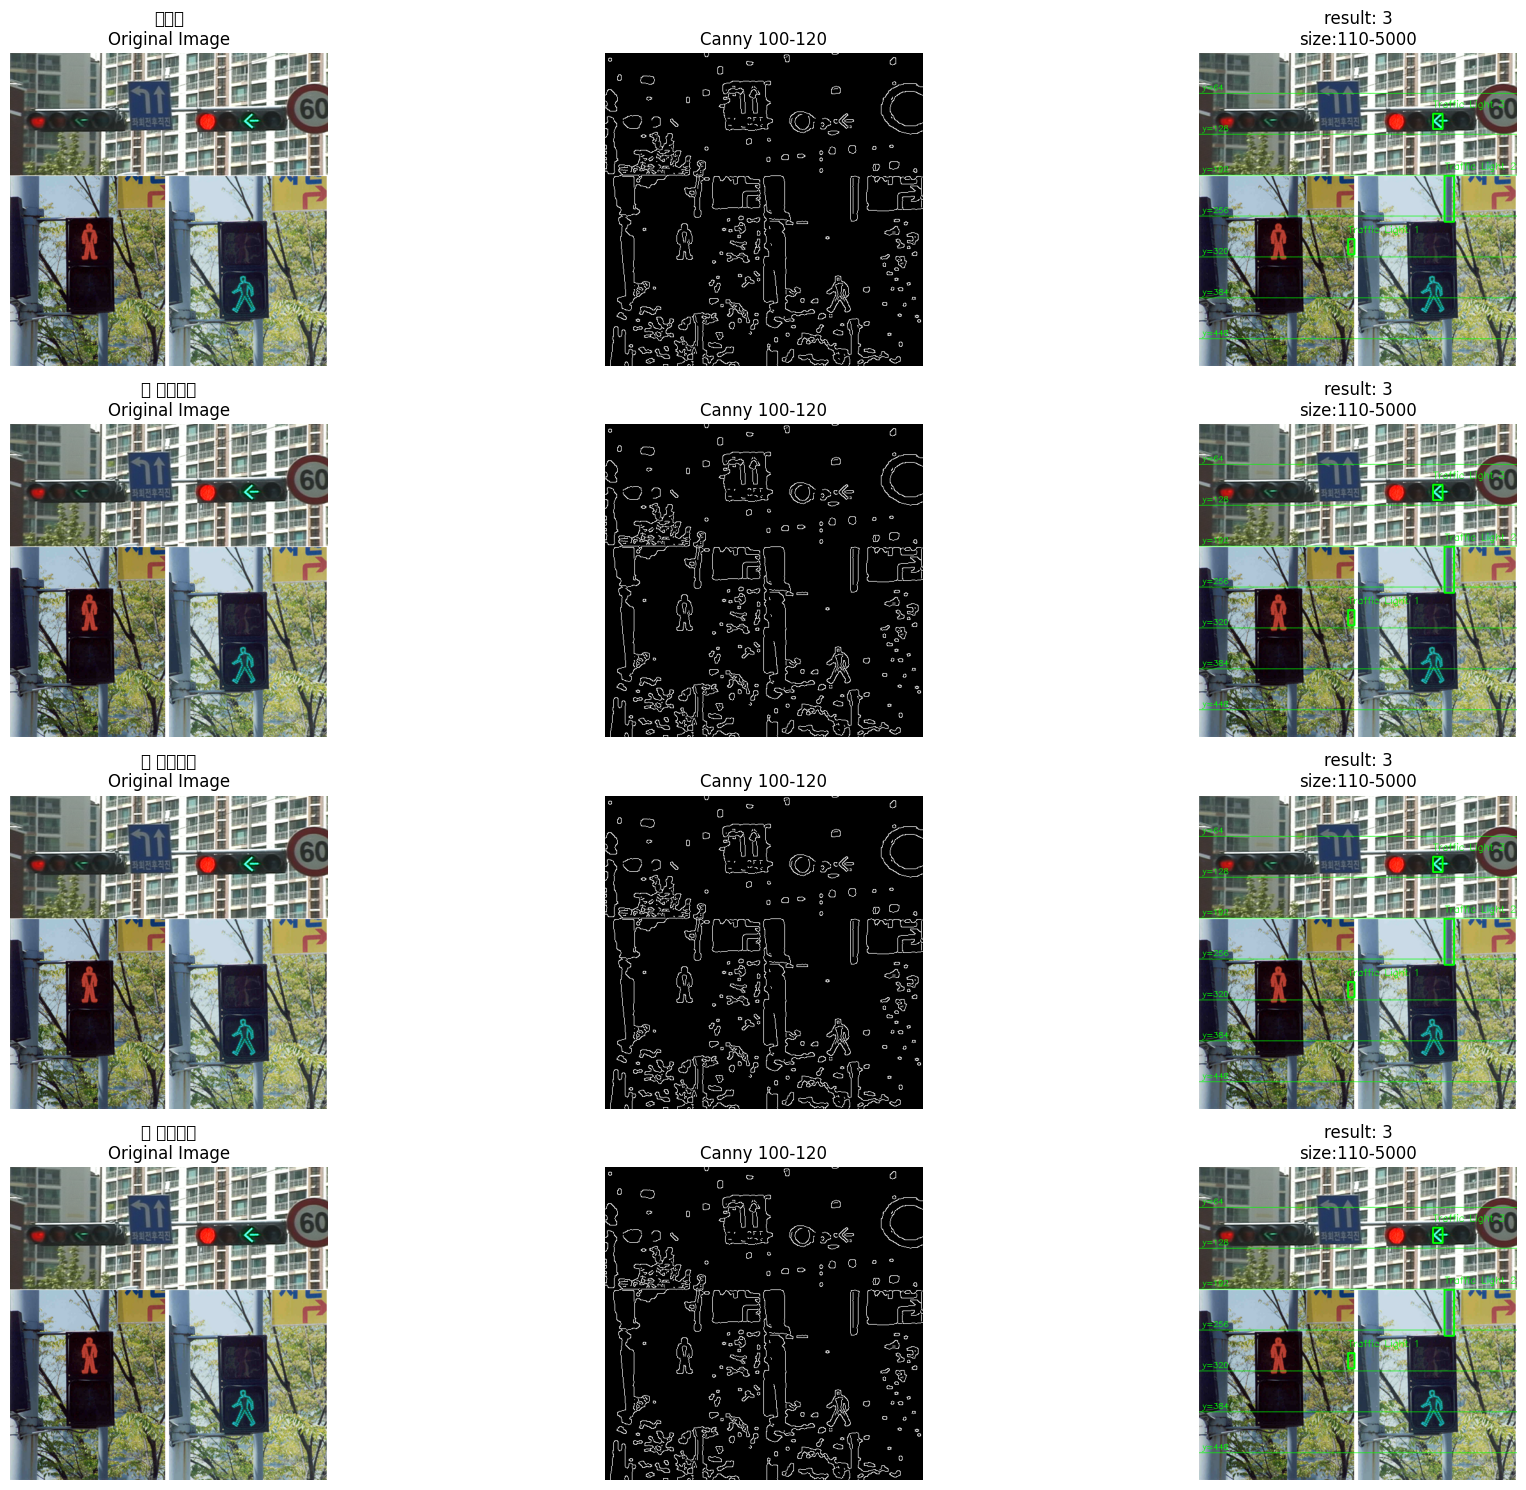


📝 어떤 설정이 가장 좋았나요?
   가장 잘 나온 파라미터를 기본값으로 사용하세요!


In [75]:
## ============================================
# 2. 내가 수정한 코드
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 색상 필터링 (신호등 색상만 찾기) – 강화된 초록 범위 포함
    if use_color_filter:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강
        red1 = cv2.inRange(hsv, np.array([0, 20, 20]),   np.array([10, 255, 255]))
        red2 = cv2.inRange(hsv, np.array([160, 20, 20]), np.array([180, 255, 255]))
        red_mask = cv2.bitwise_or(red1, red2)

        # 노랑
        yellow_mask = cv2.inRange(hsv, np.array([20, 50, 50]), np.array([30, 255, 255]))

        # 초록 (화살표까지 포함하도록 H 범위를 넓힘)
        green_mask = cv2.inRange(hsv,
            np.array([35, 50, 50]),    # H 최소 35 → 30으로 낮춰도 좋음
            np.array([100, 255, 255])  # H 최대 100 으로 확장
        )

        # 파랑(보행자)
        blue_mask = cv2.inRange(hsv, np.array([80, 50, 50]), np.array([110, 255, 255]))

        # 모든 색상 합치기
        traffic_light_mask = red_mask
        for m in [yellow_mask, green_mask, blue_mask]:
            traffic_light_mask = cv2.bitwise_or(traffic_light_mask, m)

        # Morphology to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        traffic_light_mask = cv2.morphologyEx(traffic_light_mask, cv2.MORPH_OPEN,  kernel)
        traffic_light_mask = cv2.morphologyEx(traffic_light_mask, cv2.MORPH_CLOSE, kernel)

        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.7:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"result: {len(traffic_lights)}detected!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections):
    """
    찾은 신호등 위치에 초록색 사각형을 그리는 함수
    """
    result = image.copy()

    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # 격자선 그리기
    h, w = result.shape[:2]  # result 이미지의 (행,열)을 가져옴.
    grid_size = 64  # 한 칸 크기 (픽셀 단위)
    # 가로선
    for gy in range(0, h, grid_size):  # 세로 0픽셀 ~ h픽셀까지 60픽셀 간격으로
        cv2.line(result, (0, gy), (w, gy), (0, 255, 0), 1)  #  0픽셀 ~ w픽셀까지 60픽셀 간격으로 # x좌표가 60픽셀 간격인 (gx,0)~(gx~h)까지, (RGB 초록색), (1)두께의 선을 그림. x1==x2인 동안 수직선(세로선)이 그려짐.
        cv2.putText(
            result,
            f'y={gy}',               # 표시할 텍스트
            (5, gy - 5),             # (x, y) 위치: 왼쪽 경계에서 5px, 선 위쪽 5px
            cv2.FONT_HERSHEY_SIMPLEX,
            0.4,                     # 글자 크기
            (0, 255, 0),             # 글자 색
            1                        # 두께
        )
    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")

def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 110, "max_area": 5000, "canny_low": 100, "canny_high": 120, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 110, "max_area": 5000, "canny_low": 100, "canny_high": 120, "circularity": 0.3},
        {"name": "더 엄격하게", "min_area": 110, "max_area": 5000, "canny_low": 100, "canny_high": 120, "circularity": 0.3},
        {"name": "큰 신호등용", "min_area": 110, "max_area": 5000, "canny_low": 100, "canny_high": 120, "circularity": 0.3}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\nOriginal Image')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'result: {len(detections)}\nsize:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=100,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny edge\n(Improved parameters)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'traffic light detect result\n {len(detections)}detected!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 갯수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=100,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요
#upload_and_detect()
#upload_multiple_images()
adjust_parameters_and_test()
#compare_with_without_color()

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (63).png

🖼️  파일 처리 시작: KakaoTalk_20250708_085906042 (63).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 825개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 2.5, 최소: 100)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 100)
  윤곽선 15 검사 중..

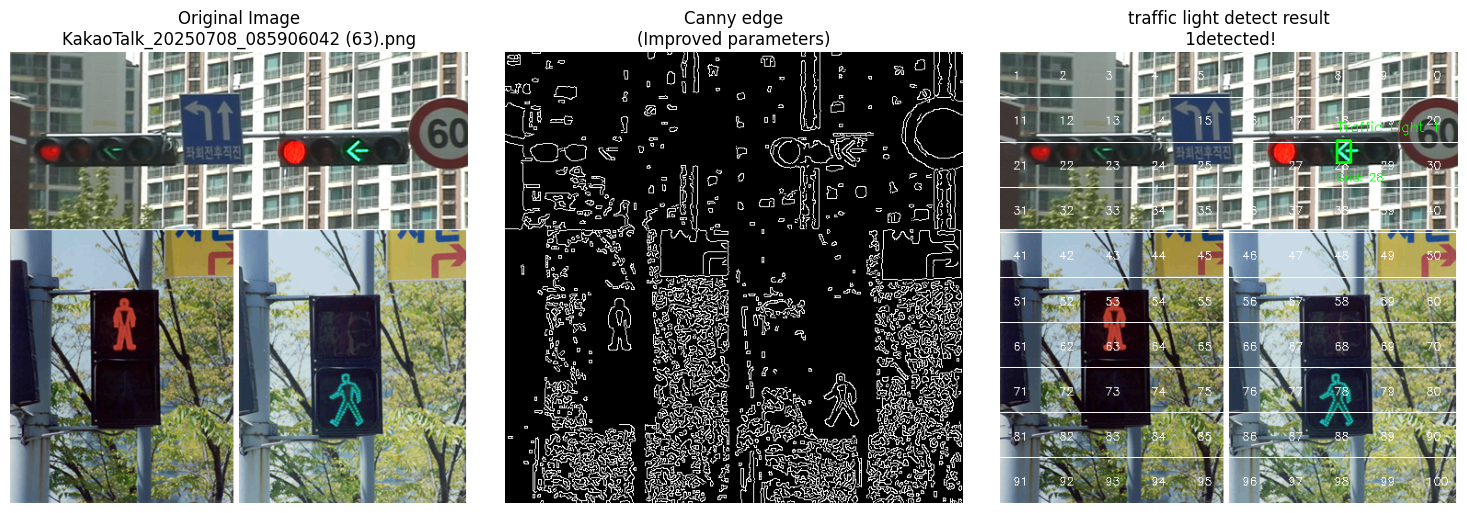


📋 최종 결과:
   검출된 신호등 갯수: 1개
   🚦 신호등 1: 위치=(366, 96), 크기=(15 x 24)


In [82]:
## ============================================
# 3 초보자를 위한 신호등 인식 코드 교수님 버전.
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=80, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 20, 20])
        red_upper1 = np.array([10, 255, 255])
        red_lower2 = np.array([160, 20, 20])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([11, 30, 30])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.7:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"result: {len(traffic_lights)}detected!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections, draw_grid=True):
    """
    검출된 신호등에 초록색 박스 그리기 + 10등분 격자선 추가
    """
    result = image.copy()

    # 격자선 그리기
    if draw_grid:
        height, width = image.shape[:2]

        # 가로선 (10등분)
        for i in range(1, 10):
            y = int(height * i / 10)
            cv2.line(result, (0, y), (width, y), (255, 255, 255), 1)  # 흰색 가로선

        # 격자 번호 추가 (구역 표시)
        for i in range(10):
            for j in range(10):
                x_center = int(width * (j + 0.5) / 10)
                y_center = int(height * (i + 0.5) / 10)
                grid_number = i * 10 + j + 1
                cv2.putText(result, str(grid_number), (x_center - 10, y_center + 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # 신호등 검출 박스 그리기
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # 각 신호등이 어느 격자에 위치하는지 표시
        center_x = x + w // 2
        center_y = y + h // 2
        height, width = image.shape[:2]

        grid_col = int(center_x * 10 / width)
        grid_row = int(center_y * 10 / height)
        grid_number = grid_row * 10 + grid_col + 1

        cv2.putText(result, f'Grid: {grid_number}', (x, y + h + 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")

def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\nOriginal Image')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'result: {len(detections)}\nsize:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=100,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny edge\n(Improved parameters)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'traffic light detect result\n {len(detections)}detected!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 갯수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=100,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요
upload_and_detect()
# upload_multiple_images()
# adjust_parameters_and_test()

🚦 개선된 신호등 인식 프로그램
1️⃣ upload_and_detect() - 2개 신호등 모두 인식
2️⃣ compare_parameters() - 파라미터 비교

💡 추천: upload_and_detect() 를 실행하세요!
🚦 개선된 신호등 인식 시작!


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (62).png

처리중: KakaoTalk_20250708_085906042 (62).png
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (30-120)
Step 4: 929개 윤곽선 발견
최종 결과: 39개 신호등 발견


/tmp/ipython-input-81-2479877058.py:215: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-81-2479877058.py:215: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-81-2479877058.py:215: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-81-2479877058.py:215: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-81-2479877058.py:215: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-81-2479877058.py:215: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-81-2479877058.py:215: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) Dej

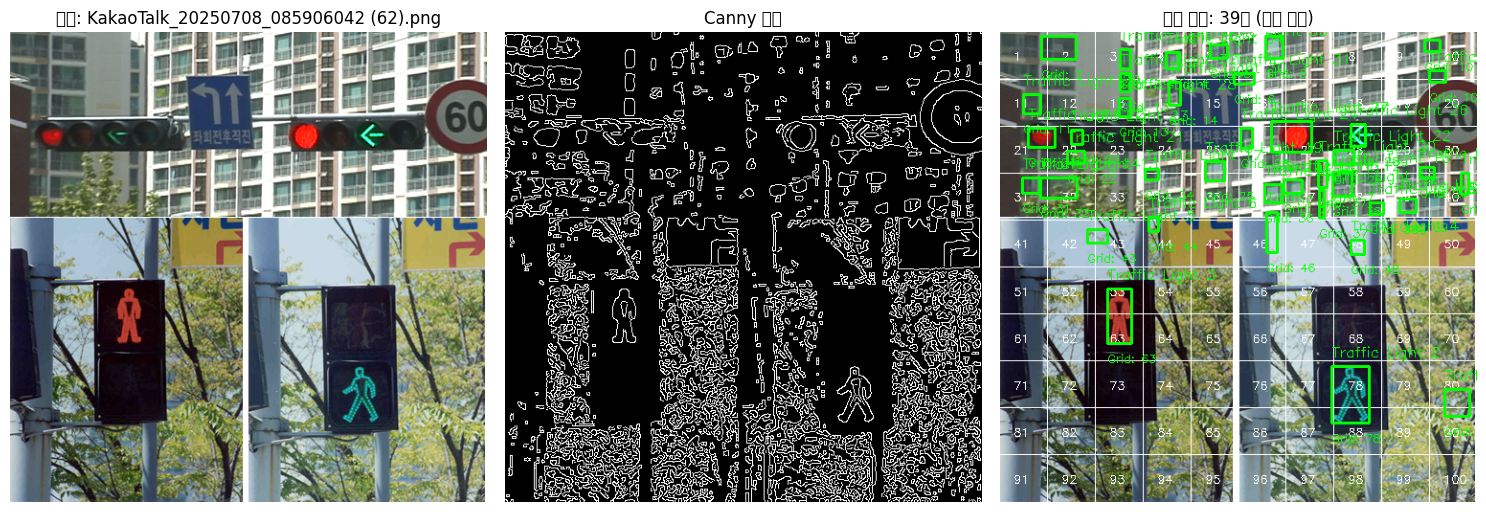

검출된 신호등 개수: 39개
  신호등 1: 위치=(464, 373), 크기=(26x28), 격자=80
  신호등 2: 위치=(346, 349), 크기=(39x59), 격자=78
  신호등 3: 위치=(112, 268), 크기=(25x57), 격자=63
  신호등 4: 위치=(366, 217), 크기=(14x15), 격자=48
  신호등 5: 위치=(91, 206), 크기=(21x14), 격자=43
  신호등 6: 위치=(155, 193), 크기=(10x15), 격자=44
  신호등 7: 위치=(278, 188), 크기=(11x42), 격자=46
  신호등 8: 위치=(386, 178), 크기=(14x12), 격자=38
  신호등 9: 위치=(417, 174), 크기=(17x14), 격자=39
  신호등 10: 위치=(333, 165), 크기=(5x29), 격자=37
  신호등 11: 위치=(276, 159), 크기=(18x19), 격자=36
  신호등 12: 위치=(296, 154), 크기=(19x14), 격자=37
  신호등 13: 위치=(42, 152), 크기=(38x21), 격자=32
  신호등 14: 위치=(23, 152), 크기=(18x16), 격자=31
  신호등 15: 위치=(481, 147), 크기=(8x22), 격자=40
  신호등 16: 위치=(347, 146), 크기=(20x25), 격자=38
  신호등 17: 위치=(151, 143), 크기=(14x11), 격자=34
  신호등 18: 위치=(438, 141), 크기=(15x11), 격자=29
  신호등 19: 위치=(214, 135), 크기=(20x20), 격자=25
  신호등 20: 위치=(332, 134), 크기=(9x28), 격자=37
  신호등 21: 위치=(70, 124), 크기=(18x13), 격자=22
  신호등 22: 위치=(348, 123), 크기=(21x15), 격자=28
  신호등 23: 위치=(74, 102), 크기=(12x15), 격자=22
  신호등 24: 위치

In [81]:
# ============================================
# 횡단보도 녹색+ 좌회전 녹색+ 빨강 횡단보도신호등 5개 검출성공했으나, 상단이 지저분한 결과가 나온 교수님의 코드
# ============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def detect_traffic_light_canny(image, min_area=50, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.2, use_color_filter=True):
    """
    색상 필터링 + Canny 엣지 검출로 신호등 인식
    """

    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 50, 50])
        red_upper1 = np.array([15, 255, 255])
        red_lower2 = np.array([170, 50, 50])
        red_upper2 = np.array([180, 255, 255])

        # 노랑색 범위
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])

        # 초록색 범위
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])

        # 파란색/청록색 범위 (보행자 신호등용)
        blue_lower = np.array([80, 30, 30])
        blue_upper = np.array([100, 255, 255])

        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)  # 수정: 괄호 제거

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

        # 모든 색상 마스크 합치기
        traffic_light_mask = red_mask
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)

        # 마스크 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료")
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 흑백 변환 완료")

    # 가우시안 블러
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # Canny 엣지 검출
    edges = cv2.Canny(blurred, canny_low, canny_high)
    print(f"Step 3: 엣지 검출 완료 ({canny_low}-{canny_high})")

    # 컨투어 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개 윤곽선 발견")

    # 신호등 후보 필터링
    traffic_lights = []
    image_height = image.shape[0]

    for i, contour in enumerate(contours):
        # 면적 체크
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue

        # 위치 체크
        x, y, w, h = cv2.boundingRect(contour)
       # if y > image_height * 0.9:  # 하단10%는 제외 (더 관대하게)
        # 위치 체크 (상단 15% 제거, 하단 25% 제거)  추가 수정11시51분
        # 기존 코드의 이 부분을:
        if y < image_height * 0.15 or y > image_height * 0.75:

        # 이렇게 수정:
            center_y = y + h // 2
        if (center_y >= image_height * 0.45 and center_y <= image_height * 0.60):

        # 종횡비 체크
           aspect_ratio = float(w) / h
           if aspect_ratio > 0.9:  # 0.8에서 0.9로 더 관대하게
               continue

        # 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > circularity_threshold:
            traffic_lights.append((x, y, w, h))

    print(f"최종 결과: {len(traffic_lights)}개 신호등 발견")
    return traffic_lights, edges

def draw_detections(image, detections, draw_grid=True):
    """
    검출된 신호등에 초록색 박스 그리기 + 10등분 격자선 추가
    """
    result = image.copy()

    # 격자선 그리기
    if draw_grid:
        height, width = image.shape[:2]

        # 세로선 (10등분)
        for i in range(1, 10):
            x = int(width * i / 10)
            cv2.line(result, (x, 0), (x, height), (255, 255, 255), 1)  # 흰색 세로선

        # 가로선 (10등분)
        for i in range(1, 10):
            y = int(height * i / 10)
            cv2.line(result, (0, y), (width, y), (255, 255, 255), 1)  # 흰색 가로선

        # 격자 번호 추가 (구역 표시)
        for i in range(10):
            for j in range(10):
                x_center = int(width * (j + 0.5) / 10)
                y_center = int(height * (i + 0.5) / 10)
                grid_number = i * 10 + j + 1
                cv2.putText(result, str(grid_number), (x_center - 10, y_center + 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # 신호등 검출 박스 그리기
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # 각 신호등이 어느 격자에 위치하는지 표시
        center_x = x + w // 2
        center_y = y + h // 2
        height, width = image.shape[:2]

        grid_col = int(center_x * 10 / width)
        grid_row = int(center_y * 10 / height)
        grid_number = grid_row * 10 + grid_col + 1

        cv2.putText(result, f'Grid: {grid_number}', (x, y + h + 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return result

def upload_and_detect():
    """
    개선된 신호등 검출 (2개 모두 인식하도록 최적화)
    """
    print("🚦 개선된 신호등 인식 시작!")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n처리중: {filename}")

        # 이미지 로드
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # 크기 조정
        height, width = image_cv.shape[:2]
        if width > 1200:
            ratio = 1200 / width
            image_cv = cv2.resize(image_cv, (1200, int(height * ratio)))

        # 신호등 검출 (최적화된 파라미터)
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=80,        # 50에서 80으로 (잡음 줄이기)
            max_area=8000,      # 충분한 범위
            canny_low=30,       # 민감한 엣지 검출
            canny_high=120,
            circularity_threshold=0.15,  # 0.2에서 0.15로 더 관대하게
            use_color_filter=True
        )

        result_image = draw_detections(image_cv, detections, draw_grid=True)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본: {filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'검출 결과: {len(detections)}개 (격자 표시)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"검출된 신호등 개수: {len(detections)}개")
        for i, (x, y, w, h) in enumerate(detections):
            # 격자 위치 계산
            center_x = x + w // 2
            center_y = y + h // 2
            height, width = image_cv.shape[:2]

            grid_col = int(center_x * 10 / width)
            grid_row = int(center_y * 10 / height)
            grid_number = grid_row * 10 + grid_col + 1

            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h}), 격자={grid_number}")

def compare_parameters():
    """
    다양한 파라미터로 비교 테스트
    """
    print("🔧 파라미터 비교 테스트!")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 4가지 파라미터 세트 테스트 (수정: 4개로 맞춤)
    param_sets = [
        {"name": "관대한 설정", "min_area": 50, "max_area": 10000, "circularity": 0.1},
        {"name": "균형 설정", "min_area": 80, "max_area": 8000, "circularity": 0.15},
        {"name": "엄격한 설정1", "min_area": 100, "max_area": 6000, "circularity": 0.25},
        {"name": "엄격한 설정2", "min_area": 500, "max_area": 10000, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))  # 수정: 4x3 그리드에 맞게 크기 조정

    for i, params in enumerate(param_sets):
        print(f"\n테스트 {i+1}: {params['name']}")

        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=30,
            canny_high=120,
            circularity_threshold=params["circularity"],
            use_color_filter=True
        )

        result = draw_detections(image_cv, detections, draw_grid=True)

        # 원본
        plt.subplot(4, 3, i*3 + 1)  # 수정: 4행으로 변경
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본')
        plt.axis('off')

        # 엣지
        plt.subplot(4, 3, i*3 + 2)  # 수정: 4행으로 변경
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지')
        plt.axis('off')

        # 결과
        plt.subplot(4, 3, i*3 + 3)  # 수정: 4행으로 변경
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개')
        plt.axis('off')

        print(f"  {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

# 실행 옵션
print("🚦 개선된 신호등 인식 프로그램")
print("1️⃣ upload_and_detect() - 2개 신호등 모두 인식")
print("2️⃣ compare_parameters() - 파라미터 비교")
print()
print("💡 추천: upload_and_detect() 를 실행하세요!")

# 바로 실행
upload_and_detect()